In [ ]:
# pip install opencv-python
# pip install tessaract

# Link para descargar el ejecutable de tesseract: https://github.com/UB-Mannheim/tesseract/wiki

In [1]:
import pandas as pd
import numpy as np
import pytesseract
pytesseract.pytesseract.tesseract_cmd = r'C:/Program Files/Tesseract-OCR/tesseract.exe'
import warnings
warnings.filterwarnings('ignore')
import os
os.getcwd()

'c:\\Users\\laura\\OneDrive - Universidad Politécnica de Madrid\\ABC_upm\\VSC\\Information_retrieval\\Assignment2'

# 1. Load Images

In [2]:
def get_images_paths(folder_path, df, n = 200):
    """
    Function to get the paths of the images in a folder and store them in a DataFrame
    
    :param folder_path: path of the folder where the images are stored
    :param df: DataFrame where the paths will be stored
    :param n: number of images to get | default = 200
    
    :return: DataFrame with the paths of the images
    """
    i = 0
    for root, dirs, files in os.walk(folder_path):
        for file in files:
            if file.endswith('.jpg'):
                id = len(df)
                path = os.path.join(root, file)
                df.loc[id] = [id, path]
                i += 1
                if i == n:
                    break
    return df
                


In [3]:
# DataFrame: car_id, path

cars_df = pd.DataFrame(columns=['car_id', 'path'])
cars_df = get_images_paths("..\data\Formula_one_cars\Alphatauri", cars_df)
cars_df = get_images_paths("..\data\Formula_one_cars\Ferrari", cars_df)
cars_df = get_images_paths("..\data\Formula_one_cars\Mclaren", cars_df)
cars_df = get_images_paths("..\data\Formula_one_cars\Mercedes", cars_df)
cars_df = get_images_paths("..\data\Formula_one_cars\Racingpoint", cars_df)
cars_df = get_images_paths("..\data\Formula_one_cars\Redbull", cars_df)
cars_df = get_images_paths("..\data\Formula_one_cars\Renault", cars_df)
cars_df = get_images_paths("..\data\Formula_one_cars\Williams", cars_df)
print(cars_df.shape)
cars_df.tail()

(240, 2)


,car_id,path
235,235,..\data\Formula_one_cars\Williams\00000449.jpg
236,236,..\data\Formula_one_cars\Williams\00000459.jpg
237,237,..\data\Formula_one_cars\Williams\00000499.jpg
238,238,..\data\Formula_one_cars\Williams\00000514.jpg
239,239,..\data\Formula_one_cars\Williams\00000524.jpg


In [4]:
# save df as csv
cars_df.to_csv('cars.csv', index=False)

# 2. Plot _my_image_

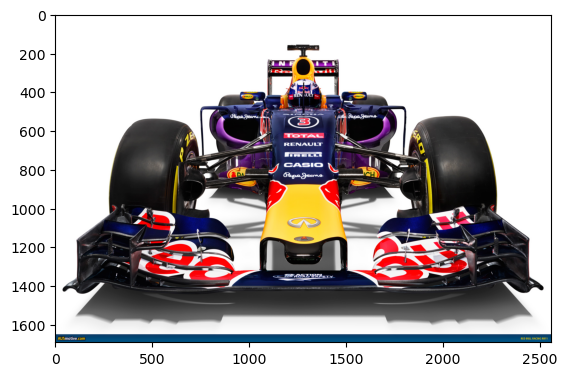

In [5]:
from PIL import Image
import matplotlib.pyplot as plt


# Our query image will be the 1033 image in the DataFrame (Alphatauri)
my_img_path = cars_df['path'][182]
my_img = Image.open(my_img_path)
plt.imshow(my_img)


# 3. Get some descriptors: Text (OCR - pytesseract) and Color (Histogram - cv2)

In [6]:
import pytesseract
import re
def ocr(path):
    """
    Function to perform OCR on an image. 
    It removes non-alphanumeric characters and returns a list of words in the image.
    
    Args:
    path: str, path to the image
    """
    img = Image.open(path)
    text = pytesseract.image_to_string(img, lang='eng')
    text = text.replace('\n', ' ')
    text = re.sub(r'[^\w\s]', '', text)
    text = text.lower()
    text = text.split()
    return text

text = ocr(my_img_path)
print('words found in my_img: ',text)

words found in my_img:  ['ausmotivecom', 'red', 'bull', 'racing', 'rb11']


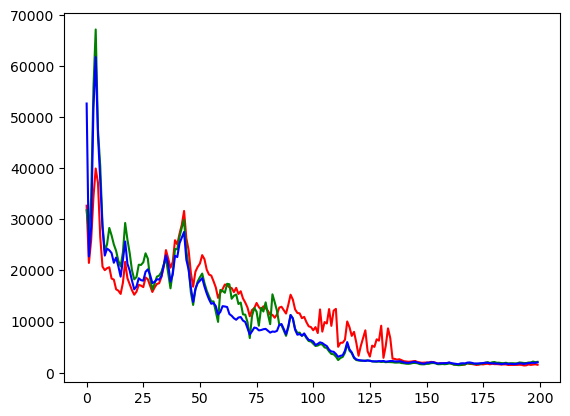

In [9]:
import cv2
my_image = cv2.imread(my_img_path)

def histogram(path, th=False, plot=False):
    img = cv2.imread(path)

    # calculate the red channel histogram
    red_hist = cv2.calcHist([my_image], [0], None, [256], [0, 256])
    green_hist = cv2.calcHist([my_image], [1], None, [256], [0, 256])
    blue_hist = cv2.calcHist([my_image], [2], None, [256], [0, 256])
    
    color = ('r', 'g', 'b')
    histogram = []
    for i, col in enumerate(color):
        color_hist = cv2.calcHist([img], [i], None, [256], [0, 256])
        if th:
            histogram.append(color_hist[0:th]) # use only the first 200 values of the histogram to avoid the white color
        else:
            histogram.append(color_hist)
    
    if plot:
        plt.plot(histogram[0], color='r')
        plt.plot(histogram[1], color='g')
        plt.plot(histogram[2], color='b')
        plt.show()

    return histogram


hist = histogram(my_img_path, th=200, plot=True)

## 3. Compare 2 images using the descriptors 

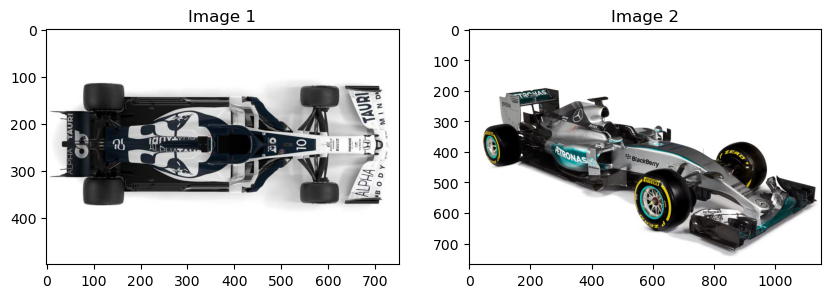

In [10]:
img_path1 = cars_df['path'][0]
img_path2= cars_df['path'][100]

# show both images
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(Image.open(img_path1))
plt.title('Image 1')
plt.subplot(1, 2, 2)
plt.imshow(Image.open(img_path2))
plt.title('Image 2')
plt.show()

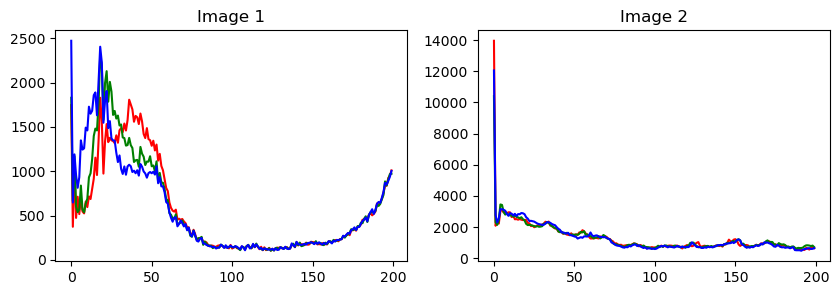

In [12]:
# Calculate bothe histograms
hist1 = histogram(img_path1, th=200, plot=False)
hist2 = histogram(img_path2, th=200, plot=False)

# plot both histograms
plt.figure(figsize=(10, 3))
plt.subplot(1, 2, 1)
plt.plot(hist1[0], color='r')
plt.plot(hist1[1], color='g')
plt.plot(hist1[2], color='b')
plt.title('Image 1')
plt.subplot(1, 2, 2)
plt.plot(hist2[0], color='r')
plt.plot(hist2[1], color='g')
plt.plot(hist2[2], color='b')
plt.title('Image 2')
plt.show()

In [18]:
# Calculate the correlation between the histograms
def compare_histograms(hist1, hist2, print_results=False):
    correlation_r = cv2.compareHist(hist1[0], hist2[0], cv2.HISTCMP_CORREL)
    intersection_r = cv2.compareHist(hist1[0], hist2[0], cv2.HISTCMP_INTERSECT)
    correlation_g = cv2.compareHist(hist1[1], hist2[1], cv2.HISTCMP_CORREL)
    intersection_g = cv2.compareHist(hist1[1], hist2[1], cv2.HISTCMP_INTERSECT)
    correlation_g = cv2.compareHist(hist1[2], hist2[2], cv2.HISTCMP_CORREL)
    intersection_g = cv2.compareHist(hist1[2], hist2[2], cv2.HISTCMP_INTERSECT)
    mean_corr = (correlation_r + correlation_g + correlation_g) / 3
    mean_int = (intersection_r + intersection_g + intersection_g) / 3
    if print_results:
        print('correlation: ', mean_corr)
        print('intersection: ', mean_int)
    return mean_corr, mean_int

hist_comparative = compare_histograms(hist1, hist2, print_results=True)


correlation:  0.6740571768528607
intersection:  110863.66666666667


In [22]:
# Calculate words in the images
text1 = ocr(img_path1)
text2 = ocr(img_path2)
print('words found in img1: ', text1)
print('words found in img2: ', text2)

words found in img1:  ['a']
words found in img2:  []


In [27]:
def compare_text(text1, text2, print_results=False):
    """
    Function to compare the words in two images
    
    Args:
    text1: list, words in the first image
    text2: list, words in the second image
    print_results: bool, if True, print the results
    
    Returns:
    int, number of words in common
    """
    # count the number of words or sets of characters in common
    count = 0
    for word in text1:
        for w in text2:
            if w in word or word in w:
                count += 1
            
    if len(text1) == 0 or len(text2) == 0:
        similarity_txt = 0
    else:
        similarity_txt = count / len(text1)
    return count, similarity_txt
    

text_comparative = compare_text(['lau', 'fer','alpha'], ['laurel', 'fer', 'al'], print_results=True)
text_comparative

(3, 1.0)

# 3. Perform OCR and Color Histogram on the image set

__OCR__: Se utiliza la librería de python "pytesseract". Se eliminan caractéres no alfabéticos, se pone todo en minúscula y se realiza un split de las palabras encontradas. Se hará un recuento de las veces que una de las palabras (o secuencia de caracteres) de la imagen de referencia se encuentra en una de las palabras (o secuencias de letras) de cada imágen del set. Este valor se pondera por 0.4.

__Color Histogram__: Se calcula el histograma de colores de cada imagen del set y la de referencia y se calcula la correlación y la intersección promedio entre los valores RGB de ambas. Tendrán una ponderación de 0.4 y 0.2 respectivamente.

 * cv2.HISTCMP_CORREL is a constant used in the OpenCV library for histogram comparison. It stands for correlation and is one of the methods to compare histograms. Specifically, it calculates the correlation between two histograms. The value returned by this method ranges from -1 to 1, where 1 indicates a perfect match (identical histograms), 0 indicates no correlation, and -1 indicates complete dissimilarity.

Here’s how it works mathematically:

Given two histograms H1 and H2, the correlation is calculated as:

[ \text{correlation} = \frac{\sum_i (H1[i] - \bar{H1}) \cdot (H2[i] - \bar{H2})}{\sqrt{\sum_i (H1[i] - \bar{H1})^2 \cdot \sum_i (H2[i] - \bar{H2})^2}} ]

Where:

(H1[i]) and (H2[i]) represent the bin values of the histograms at index (i).
(\bar{H1}) and (\bar{H2}) are the mean values of histograms H1 and H2, respectively.
In practical terms, a higher correlation value indicates greater similarity between the histograms. It’s commonly used for tasks like image matching, template matching, and object recognition.

* cv2.HISTCMP_INTERSECT: In the ImageComparator class, the intersection method is used (with flag CV_COMP_INTERSECT). This method simply compares, for each bin, the two values in each histogram, and keeps the minimum one. The similarity measure is then simply the sum of these minimum values. Consequently, two images having histograms with no colors in common would get an intersection value of 0, while two identical histograms would get a value equal to the total number of pixels.

__NOTA:__ Deberíamos buscar algún paper donde realicen esto de la intersección y la correlación para ponerlo en el documento como referencia. Y explicar un poco que significa cada uno.

In [33]:
def perform_comparation(my_img_path, cars_df, n1=0.5, n2=0.5):
    """
    Function to compare an image with the images in a DataFrame
    
    Args:
    my_img_path: str, path to the image to compare
    cars_df: DataFrame, DataFrame with the images to compare
    n1: float, weight of the histogram comparison
    n2: float, weight of the text comparison
    
    Returns:
    
    """
    # calculate histogram of my_img query
    my_hist = histogram(my_img_path, th=200, plot=False)
    # calculate words in my_img query
    my_text = ocr(my_img_path)
    
    RESULTS = []
    VALUES = []
    
    for i, img in cars_df.iterrows():
        img_path = img['path']
        if img_path != my_img_path:
            # calculate histogram of the image
            hist = histogram(img_path, th=200, plot=False)
            # calculate words in the image
            text = ocr(img_path)
            
            # compare histograms
            _, hist_comparative = compare_histograms(my_hist, hist, print_results=False)
            # compare words
            _, text_comparative = compare_text(my_text, text, print_results=False)
            
            value = n1*hist_comparative + n2*text_comparative
            
            RESULTS.append([img_path, hist_comparative, text_comparative])
            VALUES.append([img_path, value])
    
    values_df = pd.DataFrame(VALUES, columns=['car_id', 'similarity_value'])
    results_df = pd.DataFrame(RESULTS, columns=['car_id', 'hist_correlation', 'text_similarity'])
    
    return values_df, results_df

values_df, results_df = perform_comparation(my_img_path, cars_df, n1=0.5, n2=0.5)
            
            
        

In [34]:
values_df.head()

,car_id,similarity_value
0,..\data\Formula_one_cars\Alphatauri\00000018.jpg,56476.033333
1,..\data\Formula_one_cars\Alphatauri\00000022.jpg,775739.833333
2,..\data\Formula_one_cars\Alphatauri\00000024.jpg,337226.500000
3,..\data\Formula_one_cars\Alphatauri\00000031.jpg,89041.666667
4,..\data\Formula_one_cars\Alphatauri\00000061.jpg,125834.333333


In [38]:
# sort df by similarity
values_df = values_df.sort_values(by='similarity_value', ascending=False)
values_df

,car_id,similarity_value
180,..\data\Formula_one_cars\Redbull\00000457.jpg,1.008858e+06
146,..\data\Formula_one_cars\Racingpoint\00000457.jpg,9.439221e+05
82,..\data\Formula_one_cars\Mclaren\00000367.jpg,8.894020e+05
98,..\data\Formula_one_cars\Mclaren\00000517.jpg,8.857832e+05
39,..\data\Formula_one_cars\Ferrari\00000218.jpg,8.719767e+05
...,...,...
184,..\data\Formula_one_cars\Renault\0000000002.jpg,1.487117e+04
36,..\data\Formula_one_cars\Ferrari\00000186.jpg,1.321983e+04
72,..\data\Formula_one_cars\Mclaren\00000264.jpg,1.195383e+04
161,..\data\Formula_one_cars\Redbull\00000201.jpg,8.030500e+03


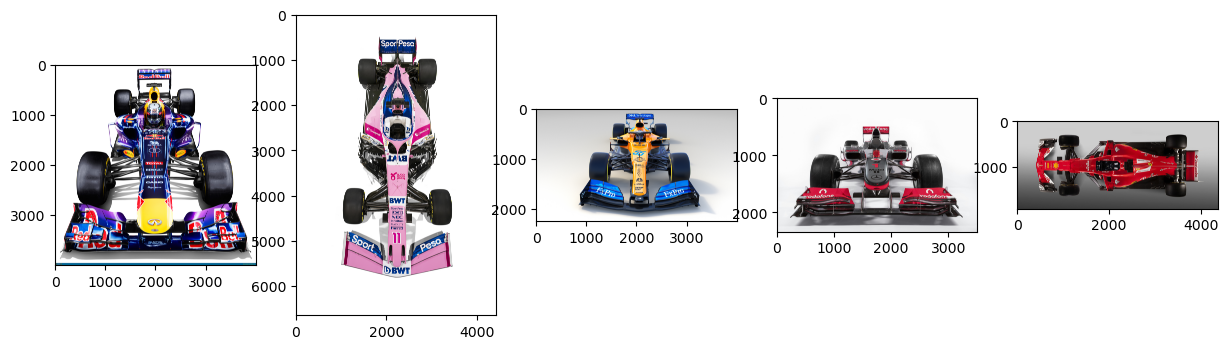

In [42]:
# show first 5 images

plt.figure(figsize=(15, 5))
for i in range(5):
    plt.subplot(1, 5, i+1)
    plt.imshow(Image.open(values_df['car_id'].iloc[i]))
    
plt.show()

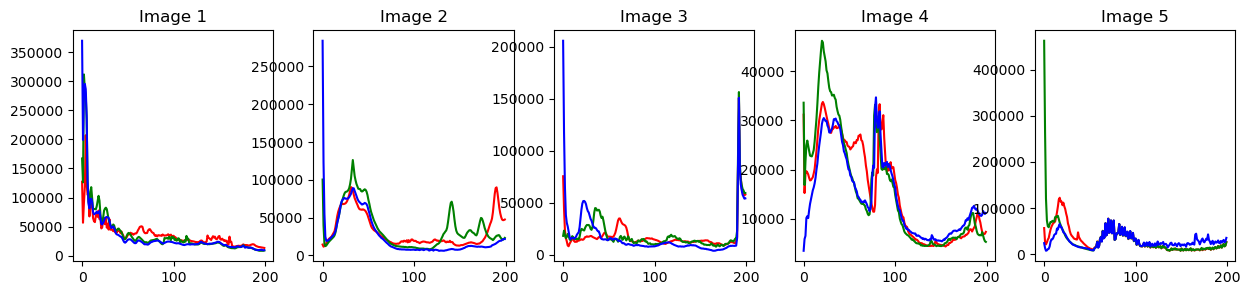

In [44]:
# print the histograms for the first 5 images
plt.figure(figsize=(15, 3))
for i in range(5):
    plt.subplot(1, 5, i+1)
    hist = histogram(values_df['car_id'].iloc[i], th=200, plot=False)
    plt.plot(hist[0], color='r')
    plt.plot(hist[1], color='g')
    plt.plot(hist[2], color='b')
    plt.title('Image ' + str(i+1))
plt.show()

In [45]:
# print the words in the first 5 images
for i in range(5):
    text = ocr(values_df['car_id'].iloc[i])
    print('words in image ', i+1, ': ', text)
    print('-----------------------------------')
    
# print the similarity values for the first 5 images
values_df.head()


words in image  1 :  []
-----------------------------------
words in image  2 :  ['caar', 'daca', 'wewi', 'l', 'ww', 'ww', 'ma', 'sportpesa', 'nec', 'infinitum', 'ss', 'hackett']
-----------------------------------
words in image  3 :  []
-----------------------------------
words in image  4 :  ['oe', '7odafone', 'dafone', '_', 'se', 'sclulttctéc', 'co', 'ee', '_', 'y', 'ss', 'neos', '4', 'n']
-----------------------------------
words in image  5 :  ['s22', 'is', 'iss', 'q', 'b']
-----------------------------------


,car_id,similarity_value
180,..\data\Formula_one_cars\Redbull\00000457.jpg,1.008858e+06
146,..\data\Formula_one_cars\Racingpoint\00000457.jpg,9.439221e+05
82,..\data\Formula_one_cars\Mclaren\00000367.jpg,8.894020e+05
98,..\data\Formula_one_cars\Mclaren\00000517.jpg,8.857832e+05
39,..\data\Formula_one_cars\Ferrari\00000218.jpg,8.719767e+05
